In [1]:
import numpy as np
import os
import pandas as pd

from_scratch = False

#X is representation of candidates (TODO: how to find reps?)
# Y is votes
# Z is census data (TODO: Add income)

vote_directory = "Data/2012_Election/election-2012-results/data"
df = pd.concat([
    pd.read_csv("{}/{}".format(vote_directory, filename), header=0, sep=',') for filename in os.listdir(vote_directory) if ".csv" in filename])
df.head()

,candidate,county,fips,precinct,town,votes
0,MITT ROMNEY AND PAUL RYAN,Aitkin,27001.0,NaN,NaN,4533
1,BARACK OBAMA AND JOE BIDEN,Aitkin,27001.0,NaN,NaN,4412
2,GARY JOHNSON AND JIM GRAY,Aitkin,27001.0,NaN,NaN,80
3,JAMES HARRIS AND MAURA DELUCA,Aitkin,27001.0,NaN,NaN,6
4,VIRGIL GOODE AND JIM CLYMER,Aitkin,27001.0,NaN,NaN,9


In [2]:
Y_dict = {}
extract = lambda x: [xi[0] for xi in x]
fips = extract(df[["fips"]].values)
precincts = extract(df[["precinct"]].values)
votes     = extract(df[["votes"]].values)
candidates  = extract(df[["candidate"]].values)
counties  = extract(df[["county"]].values)
for i in range(len(df)):
    if fips[i] > 0:
        try:
            Y_dict[fips[i]][candidates[i]] = votes[i]
        except KeyError:
            Y_dict[fips[i]] = {candidates[i]: votes[i]}
print(len(Y_dict))

all_candidates = set([])
for d in Y_dict.values():
    all_candidates.update(list(d.keys()))
#print(all_candidates)
obama_aliases = [c for c in all_candidates if "obama" in c.lower()]
romney_aliases = [c for c in all_candidates if "romney" in c.lower()]
goode_aliases = [c for c in all_candidates if "goode" in c.lower()]
johnson_aliases = [c for c in all_candidates if "johnson" in c.lower()]
stein_aliases  = [c for c in all_candidates if "stein" in c.lower()]

3113


In [3]:
Y = []
selected_fips = []
good_idx = []
for i, (fip, d) in enumerate(Y_dict.items()):
    o_total = 0
    for o_alias in obama_aliases:
        try:
            o_total += d[o_alias]
        except KeyError:
            continue
    r_total = 0
    for r_alias in romney_aliases:
        try:
            r_total += d[r_alias]
        except KeyError:
            continue
    g_total = 0
    for g_alias in goode_aliases:
        try:
            g_total += d[g_alias]
        except KeyError:
            continue
    j_total = 0
    for j_alias in johnson_aliases:
        try:
            j_total += d[j_alias]
        except KeyError:
            continue
    s_total = 0
    for s_alias in stein_aliases:
        try:
            s_total += d[s_alias]
        except KeyError:
            continue
    selected_fips.append(fip)
    Y.append([o_total, r_total, j_total])#[o_total, r_total, g_total, j_total, s_total])
    good_idx.append(i)

Y = np.array(Y)
print(Y)
selected_fips = np.array(selected_fips)
have_y = np.where(np.sum(Y, axis=1) > 0)
good_idx = np.array(good_idx)[have_y]
Y = Y[have_y]
selected_fips = selected_fips[have_y]

[[1540 3606    0]
 [2311 8975   41]
 [ 764 2152   95]
 ...
 [2924 1415  113]
 [2285 1985   28]
 [1000 3930   54]]


In [4]:
census_dir = "Data/2010_Census"
dfs = []
for filename in os.listdir(census_dir):
    if ".csv" in filename:
        #print(filename)
        try:
            dfs.append(pd.read_csv("{}/{}".format(census_dir, filename), header=0, sep=','))
        except:
            print("Error with file {}".format(filename))
            continue
df = pd.concat(dfs)

Error with file cc-est2016-alldata-35.csv


In [5]:
if from_scratch:
    covar_names = df.columns.values[7:]
    fips_set = set(list(map(int, selected_fips)))
    covars_by_fips = {}
    states = df[["STATE"]].values
    #counties = df[["COUNTY"]].values
    print(counties)
    age_groups = df[["AGEGRP"]].values
    for i in range(len(df)):
        fip = states[i][0]*1000 + counties[i][0]
        if int(fip) in fips_set and df[["YEAR"]].values[i] == 1:
            print("{},    {}         ".format(len(covars_by_fips), i), end='\r')
            try:
                age_grp = age_groups[i][0]
                covars = list(map(lambda x: df[[x]].values[i][0], covar_names))
                covars_by_fips[fip][age_grp] = covars
            except KeyError:
                covars_by_fips[fip] = {age_grp: covars}#{age_grp : list(map(lambda x: df[[x]].values[i][0], covar_names))}
        else:
            continue
    np.save("covars.npy", covars_by_fips)

In [6]:
covars_by_fips = np.load("covars.npy")
covars_by_fips = covars_by_fips.sum()
Y_final = []
Z_final = []
X_final = []
fips_final = []
counties_final = []
for i in range(len(Y)):
    try:
        my_covars = covars_by_fips[selected_fips[i]]
        #total_pop = sum(list(map(lambda x: int(my_covars[x][0]), range(1, 19))))
        #X_final.append(total_pop)
        my_covars_flat = []
        for j in range(1, 19):
            my_covars_flat.extend(my_covars[j])
        covars_sum = np.sum(my_covars_flat)
        my_covars_flat = np.hstack((my_covars_flat, np.array([covars_sum]) )) # Final value is the total population
        Z_final.append(my_covars_flat) # Testing with normalized Z_final.
        Y_final.append(Y[i, :])
        fips_final.append(selected_fips[i])
        counties_final.append(counties[good_idx[i]])
    except KeyError:
        continue
Y_final = np.array(Y_final)
Z_final = np.array(Z_final)
X_final = np.array(X_final)
print(Z_final.shape)
print(X_final.shape)
print(Y_final.shape)
np.save("fips.npy", fips_final)
np.save("counties.npy", counties_final)
#for i, fip in enumerate(fips_final):
#    if int(fip / 1000) == 42:
#        print(counties_final[i])

(2847, 1315)
(0,)
(2847, 3)


In [7]:
# Add representations to X
# https://www.nationalpriorities.org/analysis/2012/election-2012-voter-guide/voter-guide-2012-obama-and-romney-issues/
#X_constant_names = ["Job Creation", "Education", "ACA"]
# TODO: How to do this?
#X_constant_romney = [0., -1., 0., 0., -1.]
#X_constant_obama  = [1., 1., 1., 1., 1.]
#X = np.hstack((np.expand_dims(X_final, 1), np.tile(X_constant_romney, (len(X), 1))))
candidate_reps = {}
with open("Data/2012_Election/Candidate_Representations/representations.csv", 'r') as csvfile:
    for i, line in enumerate(csvfile):
        if i == 0:
            header = line.split(",")
        else:
            candidate_reps[line.split(',')[0]] = line.split(",")[1:]


#X = np.array([candidate_reps["Obama"], candidate_reps["Romney"], candidate_reps["Goode"], candidate_reps["Johnson"],
#             candidate_reps["Stein"]])
X = np.array([candidate_reps["Obama"], candidate_reps["Romney"], candidate_reps["Johnson"]])
#X = X.flatten()


#X = np.hstack((X[0, :], X[1, :], X[2, :], X[3, :], X[4, :]))
X = np.hstack((X[i, :] for i in range(X.shape[0])))
X = np.tile(X, (len(Y_final), 1))
#X = np.hstack((X, np.tile(X_constant_obama,  (len(X), 1))))
print(X.shape)

(2847, 225)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
Y_final = normalize(Y_final, axis=1, norm='l1')
print(Y_final)
X_final = normalize(X, axis=1, norm='l1')
print(X_final)
X_train, X_test, Y_train, Y_test, Z_train, Z_test, fips_train, fips_test, counties_train, counties_test = train_test_split(
    X_final, Y_final, Z_final, fips_final, counties_final, test_size=0.25)

if Z_train.shape[1] > 10:
    print("Reducing Z size...", end=' ')
    from sklearn.decomposition import PCA
    pca = PCA(n_components=10)
    Z_train = np.hstack((pca.fit_transform(Z_train[:, :-1]), np.expand_dims(Z_train[:, -1], 1)))
    Z_test  = np.hstack((pca.transform(Z_test[:, :-1]), np.expand_dims(Z_test[:, -1], 1)))
    print("Finished.")
K = Z_train.shape[1]

np.save("X_train.npy", X_train)
np.save("Y_train.npy", Y_train)
np.save("Z_train.npy", Z_train)
np.save("X_test.npy", X_test)
np.save("Y_test.npy", Y_test)
np.save("Z_test.npy", Z_test)
np.save("fips_train.npy", fips_train)
np.save("fips_test.npy", fips_test)
np.save("counties_train.npy", counties_train)
np.save("counties_test.npy", counties_test)

[[0.29926156 0.70073844 0.        ]
 [0.20402578 0.79235455 0.00361967]
 [0.2537363  0.71471272 0.03155098]
 ...
 [0.65678347 0.31783468 0.02538185]
 [0.53164262 0.46184272 0.00651466]
 [0.20064205 0.78852327 0.01083467]]
[[ 0.00595238  0.         -0.00595238 ...  0.00595238 -0.00595238
   0.        ]
 [ 0.00595238  0.         -0.00595238 ...  0.00595238 -0.00595238
   0.        ]
 [ 0.00595238  0.         -0.00595238 ...  0.00595238 -0.00595238
   0.        ]
 ...
 [ 0.00595238  0.         -0.00595238 ...  0.00595238 -0.00595238
   0.        ]
 [ 0.00595238  0.         -0.00595238 ...  0.00595238 -0.00595238
   0.        ]
 [ 0.00595238  0.         -0.00595238 ...  0.00595238 -0.00595238
   0.        ]]
Reducing Z size... Finished.


[[-2.20809992e+04  2.87585173e+03 -1.97909022e+03 ... -3.71099594e+02
  -3.92757427e+02  3.53179000e+05]
 [-3.83551710e+04  7.25797080e+03  1.76539259e+03 ... -4.32235738e+02
  -1.91606239e+02  8.73590000e+04]
 [-3.16266342e+04  4.68438757e+03  9.29526286e+02 ... -5.22875357e+01
  -2.13577730e+02  1.95313000e+05]
 ...
 [-4.28249661e+04  8.77750466e+03  2.93564374e+03 ... -6.54922003e+02
  -6.79447024e+01  1.29460000e+04]
 [-3.31108961e+04  6.38926957e+03  1.00109880e+03 ...  3.10990500e+01
   1.29034863e+02  1.76139000e+05]
 [-1.72501289e+04 -1.37968408e+03 -2.39393379e+03 ...  4.69401053e+02
   7.76163729e+01  4.37596000e+05]]


(array([ 60., 208., 431., 488., 438., 270., 146.,  60.,  23.,  11.]),
 array([0.05793468, 0.14406505, 0.23019542, 0.31632579, 0.40245616,
        0.48858653, 0.57471689, 0.66084726, 0.74697763, 0.833108  ,
        0.91923837]),
 <a list of 10 Patch objects>)

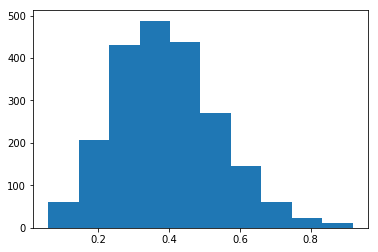

In [9]:
print(Z_train)
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(Y_train[:, 0])

(array([ 11.,  23.,  65., 153., 271., 454., 488., 433., 183.,  54.]),
 array([0.07359208, 0.15985448, 0.24611689, 0.33237929, 0.4186417 ,
        0.50490411, 0.59116651, 0.67742892, 0.76369133, 0.84995373,
        0.93621614]),
 <a list of 10 Patch objects>)

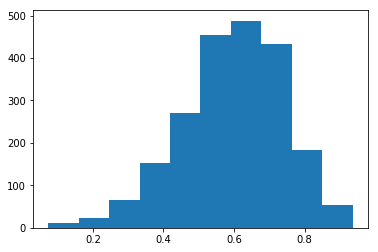

In [10]:
plt.hist(Y_train[:, 1])

NameError: name 'X_train' is not defined

In [11]:
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from distance_matching_functional import DistanceMatching
import functions
import utils

N = X_train.shape[0]
P = X_train.shape[1]
K = Z_train.shape[1]
beta_target = np.zeros((N, P))

lam=1e-5
gamma = 2e4
alpha = 1e0
upsilon = 1e-2
inter_penalty = 2e2
l2_ratio = 1.0
rho_beta = lambda beta, i: lam*(functions.lasso_penalty(beta, beta_target[i])
                                + l2_ratio*functions.l2_penalty(beta, beta_target[i])
                               + inter_penalty*(beta[-1]**2))
rho_beta_prime = lambda beta, i:lam*(functions.lasso_derivative(beta, beta_target[i])
                                     + l2_ratio*functions.l2_prime(beta, beta_target[i])
                                    + 2*inter_penalty*np.vstack((np.zeros_like(beta[:-1]), beta[-1])))

init_phi_beta = np.hstack((utils.soft_normalize(np.ones((P*Y_train.shape[1])))))
psi_beta = lambda phi_beta: 0.5*alpha*np.linalg.norm(phi_beta - init_phi_beta, ord=2)
psi_beta_prime = lambda phi_beta: alpha*(phi_beta - init_phi_beta)

init_phi_u = utils.soft_normalize(np.ones((K)))
psi_u      = lambda phi_u: upsilon*np.linalg.norm(phi_u, ord=1)
psi_u_prime = lambda phi_u: upsilon*np.sign(phi_u)

init_beta_scale=3e0
psi_beta_scale = lambda beta_scale: 1e-3*(1./beta_scale)
psi_beta_scale_prime = lambda beta_scale: -1e-3*(beta_scale**(-2))

init_beta = np.zeros((N, P))
dmr = DistanceMatching(init_beta=init_beta,
                       f=lambda x, y, b: functions.logistic_loss_multitask(x, y, b.T),
                       f_prime= lambda x, y, b: functions.logistic_loss_prime_multitask(x, y, b),
                       gamma=gamma, n_neighbors=25, calc_closest_every=5,
                       rho_beta=rho_beta,
                       rho_beta_prime = rho_beta_prime,
                       init_phi_beta = init_phi_beta,
                       psi_beta = psi_beta,
                       psi_beta_prime = psi_beta_prime,
                       init_phi_u=init_phi_u,
                       psi_u=psi_u,
                       psi_u_prime=psi_u_prime,
                       init_beta_scale=init_beta_scale,
                       psi_beta_scale=psi_beta_scale,
                       psi_beta_scale_prime=psi_beta_scale_prime,
                       intercept=False, n_threads=0)

dZ = [
    lambda x,y: functions.safe_wrapper(x, y, functions.abs_diff)
]

for _ in range(K-1):
    dZ.append(lambda x,y: functions.safe_wrapper(x, y, functions.abs_diff))

In [12]:
delta_Z = dmr.make_covariate_distances(Z_train, dZ, len(dZ), len(Z_train), should_normalize=True)

Making Co-Variate Distance Matrix of Size 2135x2135x11
Finished making unnormalized version.
Finished normalizing.
Took 167.681 seconds.


In [13]:
np.save("delta_Z.npy", delta_Z)

In [14]:
delta_Z = np.load("delta_Z.npy")

In [15]:
#print(delta_Z)
Z_train = np.load("Z_train.npy")

In [16]:
print(Z_train.shape)
print(delta_Z.shape)

(2135, 11)
(2135, 2135, 11)
